In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import griddata
from skimage import measure
import cv2
from tqdm import tqdm
import h5py

In [2]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split

### rollaxis 채널 위치 바꾸기

In [8]:
data = np.rollaxis(data, 1, 4)

In [9]:
data.shape

(8760, 75, 75, 7)

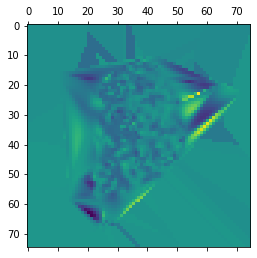

In [14]:
plt.matshow(np.flipud(data[0,:,:,1]))

# 2018

### Data Load

In [17]:
df_asos_2018 = pd.read_csv('./data/asos_2018.csv').drop('Unnamed: 0', axis=1)
df_aws_2018 = pd.read_csv('./data/aws_2018.csv').drop('Unnamed: 0', axis=1)

In [18]:
df_asos_2018.shape, df_aws_2018.shape

((831995, 36), (4279265, 9))

In [19]:
df_asos_2018.columns

Index(['지점', '일시', '기온', '기온 QC플래그', '강수량', '강수량 QC플래그', '풍속', '풍속 QC플래그',
       '풍향', '풍향 QC플래그', '습도', '습도 QC플래그', '증기압', '이슬점온도', '현지기압',
       '현지기압 QC플래그', '해면기압', '해면기압 QC플래그', '일조', '일조 QC플래그', '일사(MJ/m2)',
       '적설(cm)', '3시간신적설(cm)', '전운량', '중하층운량', '운형(운형약어)', '최저운고', '시정(10m)',
       '지면상태(지면상태코드)', '현상번호(국내식)', '지면온도(°C)', '지면온도 QC플래그', '5cm 지중온도(°C)',
       '10cm 지중온도(°C)', '20cm 지중온도(°C)', '30cm 지중온도(°C)'],
      dtype='object')

In [20]:
df_aws_2018.columns

Index(['지점', '일시', '기온', '풍향', '풍속', '강수량', '현지기압', '해면기압', '습도'], dtype='object')

In [21]:
df_all_2018 = pd.concat([df_asos_2018, df_aws_2018])

C:\Users\bigBro\Anaconda3\envs\powerplant\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [22]:
df_all_2018['일시'] = pd.to_datetime(df_all_2018['일시'])

### 좌표 변환

In [23]:
df_asos = pd.read_csv('./data/asos_kma.csv').drop('Unnamed: 0', axis=1)
df_aws = pd.read_csv('./data/aws_kma.csv')
df_coord = pd.concat([df_asos, df_aws])

In [19]:
df_asos_2018.columns

Index(['지점', '일시', '기온', '기온 QC플래그', '강수량', '강수량 QC플래그', '풍속', '풍속 QC플래그',
       '풍향', '풍향 QC플래그', '습도', '습도 QC플래그', '증기압', '이슬점온도', '현지기압',
       '현지기압 QC플래그', '해면기압', '해면기압 QC플래그', '일조', '일조 QC플래그', '일사(MJ/m2)',
       '적설(cm)', '3시간신적설(cm)', '전운량', '중하층운량', '운형(운형약어)', '최저운고', '시정(10m)',
       '지면상태(지면상태코드)', '현상번호(국내식)', '지면온도(°C)', '지면온도 QC플래그', '5cm 지중온도(°C)',
       '10cm 지중온도(°C)', '20cm 지중온도(°C)', '30cm 지중온도(°C)'],
      dtype='object')

In [24]:
df_feature_2018 = df_all_2018[['지점', '일시', '기온', '강수량', '풍속', '풍향', '습도', '현지기압', '해면기압', '전운량', '중하층운량', '최저운고']]

In [25]:
df_feature_2018 = pd.merge(df_feature_2018, df_coord[['지점','fixed_la', 'fixed_lo']])

In [50]:
test_info = df_feature_2018[df_feature_2018['일시']==df_feature_2018['일시'][0]]

In [85]:
cloud_2018 = df_feature_2018['전운량'][df_feature_2018['지점'] == 90]
len(cloud_2018)

8760

In [90]:
cloud_2018.isnull().sum()

5114

In [91]:
cloud_2018.interpolate().isnull().sum()

5088

In [105]:
s = pd.Series([0, np.nan, np.nan, np.nan, 3])
s

0    0.0
1    NaN
2    NaN
3    NaN
4    3.0
dtype: float64

In [106]:
s.interpolate()

0    0.00
1    0.75
2    1.50
3    2.25
4    3.00
dtype: float64

In [114]:
cloud_2018[5080] = np.nan

In [115]:
cloud_2018[5080:5100]

5080    NaN
5081    NaN
5082    NaN
5083    NaN
5084    NaN
5085    NaN
5086    NaN
5087    NaN
5088    2.0
5089    0.0
5090    0.0
5091    0.0
5092    1.0
5093    0.0
5094    0.0
5095    0.0
5096    0.0
5097    1.0
5098    0.0
5099    0.0
Name: 전운량, dtype: float64

In [118]:
cloud_2018.interpolate(method='nearest', limit_area='inside')[5080:5100]

5080    NaN
5081    NaN
5082    NaN
5083    NaN
5084    NaN
5085    NaN
5086    NaN
5087    NaN
5088    2.0
5089    0.0
5090    0.0
5091    0.0
5092    1.0
5093    0.0
5094    0.0
5095    0.0
5096    0.0
5097    1.0
5098    0.0
5099    0.0
Name: 전운량, dtype: float64

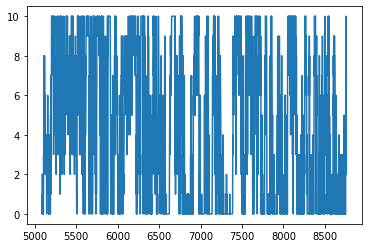

In [92]:
plt.plot(cloud_2018.interpolate())

#### 현지기압

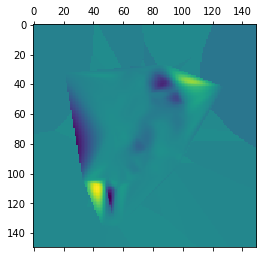

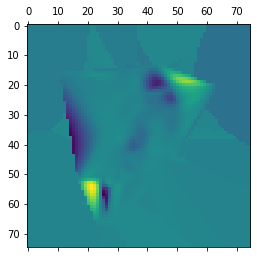

In [51]:
xi, yi = np.meshgrid(np.arange(0, 150, 1), np.arange(0, 254, 1))
zi = griddata((test_info['fixed_la'].values, test_info['fixed_lo'].values), test_info['현지기압'].values, (xi, yi),method='cubic')
mask_zi = griddata((test_info['fixed_la'].values, test_info['fixed_lo'].values), test_info['현지기압'].values, (xi, yi),method='nearest')
zi[np.isnan(zi)] = mask_zi[np.isnan(zi)]
zi[np.isnan(zi)] = np.nanmean(zi)
# plt.figure(figsize=(7,10))
# cb = plt.contourf(xi, yi, zi)
# plt.plot(test_info['fixed_la'].values, test_info['fixed_lo'].values, 'k.', ms=1)
# plt.colorbar(cb)
# plt.show()
plt.matshow(np.flipud(zi[20:170, :]))
zi = cv2.resize(zi[20:170, :], dsize=(75, 75), interpolation=cv2.INTER_NEAREST)
plt.matshow(np.flipud(zi))

### 해면기압

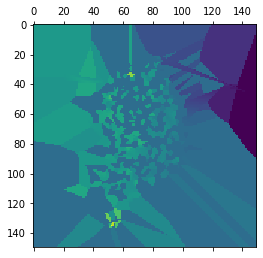

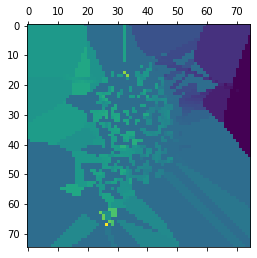

In [204]:
xi, yi = np.meshgrid(np.arange(0, 150, 1), np.arange(0, 254, 1))
zi = griddata((test_info['fixed_la'].values, test_info['fixed_lo'].values), test_info['해면기압'].values, (xi, yi),method='linear')
mask_zi = griddata((test_info['fixed_la'].values, test_info['fixed_lo'].values), test_info['해면기압'].values, (xi, yi),method='nearest')
zi[np.isnan(zi)] = mask_zi[np.isnan(zi)]
zi[np.isnan(zi)] = np.nanmean(zi)
# plt.figure(figsize=(7,10))
# cb = plt.contourf(xi, yi, zi)
# plt.plot(test_info['fixed_la'].values, test_info['fixed_lo'].values, 'k.', ms=1)
# plt.colorbar(cb)
# plt.show()
plt.matshow(np.flipud(zi[20:170, :]))
zi = cv2.resize(zi[20:170, :], dsize=(75, 75), interpolation=cv2.INTER_NEAREST)
plt.matshow(np.flipud(zi))

C:\Users\bigBro\Anaconda3\envs\powerplant\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: Mean of empty slice
  """


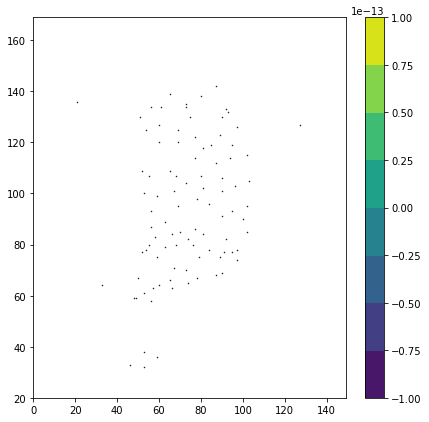

In [66]:
xi, yi = np.meshgrid(np.arange(0, 150, 1), np.arange(20, 170, 1))
zi = griddata((test_info['fixed_la'].values, test_info['fixed_lo'].values), test_info['전운량'].values, (xi, yi),method='linear')
mask_zi = griddata((test_info['fixed_la'].values, test_info['fixed_lo'].values), test_info['전운량'].values, (xi, yi),method='nearest')
zi[np.isnan(zi)] = mask_zi[np.isnan(zi)]
zi[np.isnan(zi)] = np.nanmean(zi)
plt.figure(figsize=(7,7))
cb = plt.contourf(xi, yi, zi)
plt.plot(test_info['fixed_la'].values, test_info['fixed_lo'].values, 'k.', ms=1)
plt.colorbar(cb)
plt.show()
#plt.matshow(np.flipud(zi[20:170, :]))
#zi = cv2.resize(zi[20:170, :], dsize=(75, 75), interpolation=cv2.INTER_NEAREST)
#plt.matshow(np.flipud(zi))

In [68]:
zi

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

In [71]:
sc = RobustScaler()

In [72]:
times = pd.date_range(min(df_feature_2018['일시']), max(df_feature_2018['일시']), freq='H')
data = np.zeros((len(times), 7, 75, 75))

In [73]:
times[0], times[-1], len(times)

(Timestamp('2018-01-01 01:00:00', freq='H'),
 Timestamp('2019-01-01 00:00:00', freq='H'),
 8760)

### 데이터셋 생성
### 이미지 생성 -> 다운스케일 하였음
### 다운스케일 -> 이미지 생성도 해볼 필요 있음

In [74]:
for time, i in tqdm(zip(times, range(len(times)))):
    images = np.zeros((7, 75, 75))
    test_info = df_feature_2018[df_feature_2018['일시']==time]
    
    # 기온
    xi, yi = np.meshgrid(np.arange(0, 150, 1), np.arange(0, 254, 1))
    zi = griddata((test_info['fixed_la'].values, test_info['fixed_lo'].values), test_info['기온'].values, (xi, yi),method='cubic')
    mask_zi = griddata((test_info['fixed_la'].values, test_info['fixed_lo'].values), test_info['기온'].values, (xi, yi),method='nearest')
    zi[np.isnan(zi)] = mask_zi[np.isnan(zi)]
    zi[np.isnan(zi)] = np.nanmean(zi)
    zi = cv2.resize(zi[20:170, :], dsize=(75, 75), interpolation=cv2.INTER_NEAREST)
    images[0] = sc.fit_transform(zi.flatten().reshape(-1, 1)).reshape(75, 75)
    
    # 풍향
    xi, yi = np.meshgrid(np.arange(0, 150, 1), np.arange(0, 254, 1))
    zi = griddata((test_info['fixed_la'].values, test_info['fixed_lo'].values), test_info['풍향'].values, (xi, yi),method='cubic')
    mask_zi = griddata((test_info['fixed_la'].values, test_info['fixed_lo'].values), test_info['풍향'].values, (xi, yi),method='nearest')
    zi[np.isnan(zi)] = mask_zi[np.isnan(zi)]
    zi[np.isnan(zi)] = np.nanmean(zi)
    zi = cv2.resize(zi[20:170, :], dsize=(75, 75), interpolation=cv2.INTER_NEAREST)
    images[1] = sc.fit_transform(zi.flatten().reshape(-1, 1)).reshape(75,75)
    
    # 풍속
    xi, yi = np.meshgrid(np.arange(0, 150, 1), np.arange(0, 254, 1))
    zi = griddata((test_info['fixed_la'].values, test_info['fixed_lo'].values), test_info['풍속'].values, (xi, yi),method='linear')
    mask_zi = griddata((test_info['fixed_la'].values, test_info['fixed_lo'].values), test_info['풍속'].values, (xi, yi),method='nearest')
    zi[np.isnan(zi)] = mask_zi[np.isnan(zi)]
    zi[np.isnan(zi)] = np.nanmean(zi)
    zi = cv2.resize(zi[20:170, :], dsize=(75, 75), interpolation=cv2.INTER_NEAREST)
    images[2] = sc.fit_transform(zi.flatten().reshape(-1, 1)).reshape(75,75)
    
    # 강수량
    xi, yi = np.meshgrid(np.arange(0, 150, 1), np.arange(0, 254, 1))
    zi = griddata((test_info['fixed_la'].values, test_info['fixed_lo'].values), test_info['강수량'].values, (xi, yi),method='nearest')
    mask_zi = griddata((test_info['fixed_la'].values, test_info['fixed_lo'].values), test_info['강수량'].values, (xi, yi),method='nearest')
    zi[np.isnan(zi)] = mask_zi[np.isnan(zi)]
    zi[np.isnan(zi)] = np.nanmean(zi)
    zi = cv2.resize(zi[20:170, :], dsize=(75, 75), interpolation=cv2.INTER_NEAREST)
    images[3] = sc.fit_transform(zi.flatten().reshape(-1, 1)).reshape(75,75)
    
    # 습도
    xi, yi = np.meshgrid(np.arange(0, 150, 1), np.arange(0, 254, 1))
    zi = griddata((test_info['fixed_la'].values, test_info['fixed_lo'].values), test_info['습도'].values, (xi, yi),method='linear')
    mask_zi = griddata((test_info['fixed_la'].values, test_info['fixed_lo'].values), test_info['습도'].values, (xi, yi),method='nearest')
    zi[np.isnan(zi)] = mask_zi[np.isnan(zi)]
    zi[np.isnan(zi)] = np.nanmean(zi)
    zi = cv2.resize(zi[20:170, :], dsize=(75, 75), interpolation=cv2.INTER_NEAREST)
    images[4] = sc.fit_transform(zi.flatten().reshape(-1, 1)).reshape(75,75)
    
    # 현지기압
    xi, yi = np.meshgrid(np.arange(0, 150, 1), np.arange(0, 254, 1))
    zi = griddata((test_info['fixed_la'].values, test_info['fixed_lo'].values), test_info['현지기압'].values, (xi, yi),method='cubic')
    mask_zi = griddata((test_info['fixed_la'].values, test_info['fixed_lo'].values), test_info['현지기압'].values, (xi, yi),method='nearest')
    zi[np.isnan(zi)] = mask_zi[np.isnan(zi)]
    zi[np.isnan(zi)] = np.nanmean(zi)
    zi = cv2.resize(zi[20:170, :], dsize=(75, 75), interpolation=cv2.INTER_NEAREST)
    images[5] = sc.fit_transform(zi.flatten().reshape(-1, 1)).reshape(75,75)
  
    # 해면기압
    xi, yi = np.meshgrid(np.arange(0, 150, 1), np.arange(0, 254, 1))
    zi = griddata((test_info['fixed_la'].values, test_info['fixed_lo'].values), test_info['해면기압'].values, (xi, yi),method='cubic')
    mask_zi = griddata((test_info['fixed_la'].values, test_info['fixed_lo'].values), test_info['해면기압'].values, (xi, yi),method='nearest')
    zi[np.isnan(zi)] = mask_zi[np.isnan(zi)]
    zi[np.isnan(zi)] = np.nanmean(zi)
    zi = cv2.resize(zi[20:170, :], dsize=(75, 75), interpolation=cv2.INTER_NEAREST)
    images[5] = sc.fit_transform(zi.flatten().reshape(-1, 1)).reshape(75,75)
    
    data[i] = images[:,:]

8760it [1:01:31,  2.34it/s]


In [4]:
wind_gen = pd.read_csv('./data/wind_gen.csv').drop('Unnamed: 0', axis=1)
wind_gen['일시'] = pd.to_datetime(wind_gen['일시'])

In [76]:
wind_2018 = wind_gen[(wind_gen['일시'] > pd.Timestamp('2018-01-01T01')) & (wind_gen['일시'] <= pd.Timestamp('2019-01-01T01'))]

In [77]:
len(wind_2018['발전량'].values)

8760

In [78]:
h5f = h5py.File('./data/data.h5', 'w')

In [79]:
h5f.create_dataset('total_2018', data=data)
h5f.create_dataset('gen_2018', data=wind_2018['발전량'].values)
h5f.close()

In [80]:
h5f = h5py.File('./data/data.h5','r')

In [81]:
data = h5f['total_2018'][:]
gen_data = h5f['gen_2018'][:]
h5f.close()

In [82]:
data.shape, gen_data.shape

((8760, 7, 75, 75), (8760,))

# 2017

### Data Load

In [16]:
df_asos_2017 = pd.read_csv('./data/asos_2017.csv')
df_aws_2017 = pd.read_csv('./data/aws_2017.csv')

In [17]:
df_asos_2017.shape, df_aws_2017.shape

((419074, 37), (2180770, 10))

In [18]:
df_all_2017 = pd.concat([df_asos_2017, df_aws_2017])

C:\Users\bigBro\Anaconda3\envs\powerplant\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [19]:
df_all_2017 = df_all_2017.drop('Unnamed: 0', axis=1)

In [20]:
df_all_2017['일시'] = pd.to_datetime(df_all_2017['일시'])

### 좌표 변환

In [21]:
df_asos = pd.read_csv('./data/asos_kma.csv').drop('Unnamed: 0', axis=1)
df_aws = pd.read_csv('./data/aws_kma.csv')
df_coord = pd.concat([df_asos, df_aws])

In [22]:
df_asos_2017.columns

Index(['Unnamed: 0', '지점', '일시', '기온', '기온 QC플래그', '강수량', '강수량 QC플래그', '풍속',
       '풍속 QC플래그', '풍향', '풍향 QC플래그', '습도(%)', '습도 QC플래그', '증기압', '이슬점온도',
       '현지기압', '현지기압 QC플래그', '해면기압', '해면기압 QC플래그', '일조(hr)', '일조 QC플래그',
       '일사(MJ/m2)', '적설(cm)', '3시간신적설(cm)', '전운량(10분위)', '중하층운량(10분위)',
       '운형(운형약어)', '최저운고(100m )', '시정(10m)', '지면상태(지면상태코드)', '현상번호(국내식)',
       '지면온도(°C)', '지면온도 QC플래그', '5cm 지중온도(°C)', '10cm 지중온도(°C)',
       '20cm 지중온도(°C)', '30cm 지중온도(°C)'],
      dtype='object')

In [23]:
df_aws_2017.columns

Index(['Unnamed: 0', '지점', '일시', '기온', '풍향', '풍속', '강수량', '현지기압', '해면기압',
       '습도'],
      dtype='object')

In [24]:
df_feature_2017 = df_all_2017[['지점', '일시', '기온', '풍향', '풍속', '강수량', '습도', '현지기압', '해면기압']]

In [26]:
df_feature_2017 = pd.merge(df_feature_2017, df_coord[['지점','fixed_la', 'fixed_lo']])

In [27]:
test_info = df_feature_2017[df_feature_2017['일시']==df_feature_2017['일시'][0]]

In [38]:
sc = RobustScaler()

In [40]:
times = pd.date_range(min(df_feature_2017['일시']), max(df_feature_2017['일시']), freq='H')
data = np.zeros((len(times), 7, 75, 75))

In [41]:
times[0], times[-1], len(times)

(Timestamp('2017-07-01 00:00:00', freq='H'),
 Timestamp('2018-01-01 00:00:00', freq='H'),
 4417)

In [55]:
for time, i in tqdm(zip(times, range(len(times)))):
    images = np.zeros((7, 75, 75))
    test_info = df_feature_2017[df_feature_2017['일시']==time]
    
    # 기온
    xi, yi = np.meshgrid(np.arange(0, 150, 1), np.arange(0, 254, 1))
    zi = griddata((test_info['fixed_la'].values, test_info['fixed_lo'].values), test_info['기온'].values, (xi, yi),method='cubic')
    mask_zi = griddata((test_info['fixed_la'].values, test_info['fixed_lo'].values), test_info['기온'].values, (xi, yi),method='nearest')
    zi[np.isnan(zi)] = mask_zi[np.isnan(zi)]
    zi[np.isnan(zi)] = np.nanmean(zi)
    zi = cv2.resize(zi[20:170, :], dsize=(75, 75), interpolation=cv2.INTER_NEAREST)
    images[0] = sc.fit_transform(zi.flatten().reshape(-1, 1)).reshape(75, 75)
    
    # 풍향
    xi, yi = np.meshgrid(np.arange(0, 150, 1), np.arange(0, 254, 1))
    zi = griddata((test_info['fixed_la'].values, test_info['fixed_lo'].values), test_info['풍향'].values, (xi, yi),method='cubic')
    mask_zi = griddata((test_info['fixed_la'].values, test_info['fixed_lo'].values), test_info['풍향'].values, (xi, yi),method='nearest')
    zi[np.isnan(zi)] = mask_zi[np.isnan(zi)]
    zi[np.isnan(zi)] = np.nanmean(zi)
    zi = cv2.resize(zi[20:170, :], dsize=(75, 75), interpolation=cv2.INTER_NEAREST)
    images[1] = sc.fit_transform(zi.flatten().reshape(-1, 1)).reshape(75,75)
    
    # 풍속
    xi, yi = np.meshgrid(np.arange(0, 150, 1), np.arange(0, 254, 1))
    zi = griddata((test_info['fixed_la'].values, test_info['fixed_lo'].values), test_info['풍속'].values, (xi, yi),method='linear')
    mask_zi = griddata((test_info['fixed_la'].values, test_info['fixed_lo'].values), test_info['풍속'].values, (xi, yi),method='nearest')
    zi[np.isnan(zi)] = mask_zi[np.isnan(zi)]
    zi[np.isnan(zi)] = np.nanmean(zi)
    zi = cv2.resize(zi[20:170, :], dsize=(75, 75), interpolation=cv2.INTER_NEAREST)
    images[2] = sc.fit_transform(zi.flatten().reshape(-1, 1)).reshape(75,75)
    
    # 강수량
    xi, yi = np.meshgrid(np.arange(0, 150, 1), np.arange(0, 254, 1))
    zi = griddata((test_info['fixed_la'].values, test_info['fixed_lo'].values), test_info['강수량'].values, (xi, yi),method='nearest')
    mask_zi = griddata((test_info['fixed_la'].values, test_info['fixed_lo'].values), test_info['강수량'].values, (xi, yi),method='nearest')
    zi[np.isnan(zi)] = mask_zi[np.isnan(zi)]
    zi[np.isnan(zi)] = np.nanmean(zi)
    zi = cv2.resize(zi[20:170, :], dsize=(75, 75), interpolation=cv2.INTER_NEAREST)
    images[3] = sc.fit_transform(zi.flatten().reshape(-1, 1)).reshape(75,75)
    
    # 습도
    xi, yi = np.meshgrid(np.arange(0, 150, 1), np.arange(0, 254, 1))
    zi = griddata((test_info['fixed_la'].values, test_info['fixed_lo'].values), test_info['습도'].values, (xi, yi),method='linear')
    mask_zi = griddata((test_info['fixed_la'].values, test_info['fixed_lo'].values), test_info['습도'].values, (xi, yi),method='nearest')
    zi[np.isnan(zi)] = mask_zi[np.isnan(zi)]
    zi[np.isnan(zi)] = np.nanmean(zi)
    zi = cv2.resize(zi[20:170, :], dsize=(75, 75), interpolation=cv2.INTER_NEAREST)
    images[4] = sc.fit_transform(zi.flatten().reshape(-1, 1)).reshape(75,75)
    
    # 현지기압
    xi, yi = np.meshgrid(np.arange(0, 150, 1), np.arange(0, 254, 1))
    zi = griddata((test_info['fixed_la'].values, test_info['fixed_lo'].values), test_info['현지기압'].values, (xi, yi),method='cubic')
    mask_zi = griddata((test_info['fixed_la'].values, test_info['fixed_lo'].values), test_info['현지기압'].values, (xi, yi),method='nearest')
    zi[np.isnan(zi)] = mask_zi[np.isnan(zi)]
    zi[np.isnan(zi)] = np.nanmean(zi)
    zi = cv2.resize(zi[20:170, :], dsize=(75, 75), interpolation=cv2.INTER_NEAREST)
    images[5] = sc.fit_transform(zi.flatten().reshape(-1, 1)).reshape(75,75)
  
    # 해면기압
    xi, yi = np.meshgrid(np.arange(0, 150, 1), np.arange(0, 254, 1))
    zi = griddata((test_info['fixed_la'].values, test_info['fixed_lo'].values), test_info['해면기압'].values, (xi, yi),method='cubic')
    mask_zi = griddata((test_info['fixed_la'].values, test_info['fixed_lo'].values), test_info['해면기압'].values, (xi, yi),method='nearest')
    zi[np.isnan(zi)] = mask_zi[np.isnan(zi)]
    zi[np.isnan(zi)] = np.nanmean(zi)
    zi = cv2.resize(zi[20:170, :], dsize=(75, 75), interpolation=cv2.INTER_NEAREST)
    images[5] = sc.fit_transform(zi.flatten().reshape(-1, 1)).reshape(75,75)
    
    data[i] = images[:,:]


0it [00:00, ?it/s]C:\Users\bigBro\Anaconda3\envs\powerplant\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: Mean of empty slice
C:\Users\bigBro\AppData\Roaming\Python\Python37\site-packages\numpy\lib\nanfunctions.py:959: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)
C:\Users\bigBro\AppData\Roaming\Python\Python37\site-packages\numpy\lib\function_base.py:3405: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)

1it [00:00,  4.07it/s]
2it [00:00,  3.35it/s]
3it [00:01,  2.98it/s]
4it [00:01,  2.77it/s]
5it [00:01,  2.64it/s]
6it [00:02,  2.56it/s]
7it [00:02,  2.51it/s]
8it [00:03,  2.49it/s]
9it [00:03,  2.47it/s]
10it [00:04,  2.45it/s]
11it [00:04,  2.44it/s]
12it [00:04,  2.42it/s]
13it [00:05,  2.40it/s]
14it [00:05,  2.42it/s]
15it [00:06,  2.41it/s]
16it [00:06,  2.40it/s]
17it [00:06,  2.42it/s]
18it [00:07,  2.42it/s]
19it [00:07,  2.42it/s]
20it [00:08,  2.42it/s]
21it [00:08,  2.42it

In [57]:
wind_gen.head()

,일시,발전량
0,2017-07-01 01:00:00,1.09776
1,2017-07-01 02:00:00,1.38600
2,2017-07-01 03:00:00,0.54600
3,2017-07-01 04:00:00,0.00000
4,2017-07-01 05:00:00,7.16832


In [60]:
wind_2017 = wind_gen[wind_gen['일시'] <= pd.Timestamp('2018-01-01T01')]

In [61]:
len(wind_2017['발전량'].values)

4417

In [62]:
h5f = h5py.File('./data/data_2017.h5', 'w')

In [63]:
h5f.create_dataset('total_2017', data=data)
h5f.create_dataset('gen_2017', data=wind_2017['발전량'].values)
h5f.close()

# 2019

### Data Load

In [5]:
df_asos_2019 = pd.read_csv('./data/asos_2019.csv')
df_aws_2019 = pd.read_csv('./data/aws_2019.csv')

C:\Users\bigBro\Anaconda3\envs\powerplant\lib\site-packages\IPython\core\interactiveshell.py:3057: DtypeWarning: Columns (26) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [6]:
df_asos_2019.shape, df_aws_2019.shape

((528691, 37), (2501036, 10))

In [7]:
df_all_2019 = pd.concat([df_asos_2019, df_aws_2019])

C:\Users\bigBro\Anaconda3\envs\powerplant\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [8]:
df_all_2019 = df_all_2019.drop('Unnamed: 0', axis=1)

In [9]:
df_all_2019['일시'] = pd.to_datetime(df_all_2019['일시'])

In [29]:
min(df_asos_2019['일시']), max(df_asos_2019['일시'])

('2019-01-01 01:00:00', '2019-08-21 00:00:00')

In [30]:
min(df_aws_2019['일시']), max(df_aws_2019['일시'])

('2019-01-01 01:00', '2019-08-01 00:00')

### 좌표 변환

In [11]:
df_asos = pd.read_csv('./data/asos_kma.csv').drop('Unnamed: 0', axis=1)
df_aws = pd.read_csv('./data/aws_kma.csv')
df_coord = pd.concat([df_asos, df_aws])

In [12]:
df_asos_2019.columns

Index(['Unnamed: 0', '지점', '일시', '기온(°C)', '기온 QC플래그', '강수량(mm)', '강수량 QC플래그',
       '풍속(m/s)', '풍속 QC플래그', '풍향(16방위)', '풍향 QC플래그', '습도(%)', '습도 QC플래그',
       '증기압(hPa)', '이슬점온도(°C)', '현지기압(hPa)', '현지기압 QC플래그', '해면기압(hPa)',
       '해면기압 QC플래그', '일조(hr)', '일조 QC플래그', '일사(MJ/m2)', '적설(cm)', '3시간신적설(cm)',
       '전운량(10분위)', '중하층운량(10분위)', '운형(운형약어)', '최저운고(100m )', '시정(10m)',
       '지면상태(지면상태코드)', '현상번호(국내식)', '지면온도(°C)', '지면온도 QC플래그', '5cm 지중온도(°C)',
       '10cm 지중온도(°C)', '20cm 지중온도(°C)', '30cm 지중온도(°C)'],
      dtype='object')

In [13]:
df_aws_2019.columns

Index(['Unnamed: 0', '지점', '일시', '기온', '풍향', '풍속', '강수량', '현지기압', '해면기압',
       '습도'],
      dtype='object')

In [14]:
df_feature_2019 = df_all_2019[['지점', '일시', '기온', '풍향', '풍속', '강수량', '습도', '현지기압', '해면기압']]

In [15]:
df_feature_2019 = pd.merge(df_feature_2019, df_coord[['지점','fixed_la', 'fixed_lo']])

In [16]:
test_info = df_feature_2019[df_feature_2019['일시']==df_feature_2019['일시'][0]]

In [17]:
sc = RobustScaler()

In [31]:
times = pd.date_range(min(df_feature_2019['일시']), pd.Timestamp('2019-07-01T00'), freq='H')
data = np.zeros((len(times), 7, 75, 75))

In [32]:
times[0], times[-1], len(times)

(Timestamp('2019-01-01 01:00:00', freq='H'),
 Timestamp('2019-07-01 00:00:00', freq='H'),
 4344)

In [33]:
for time, i in tqdm(zip(times, range(len(times)))):
    images = np.zeros((7, 75, 75))
    test_info = df_feature_2019[df_feature_2019['일시']==time]
    
    # 기온
    xi, yi = np.meshgrid(np.arange(0, 150, 1), np.arange(0, 254, 1))
    zi = griddata((test_info['fixed_la'].values, test_info['fixed_lo'].values), test_info['기온'].values, (xi, yi),method='cubic')
    mask_zi = griddata((test_info['fixed_la'].values, test_info['fixed_lo'].values), test_info['기온'].values, (xi, yi),method='nearest')
    zi[np.isnan(zi)] = mask_zi[np.isnan(zi)]
    zi[np.isnan(zi)] = np.nanmean(zi)
    zi = cv2.resize(zi[20:170, :], dsize=(75, 75), interpolation=cv2.INTER_NEAREST)
    images[0] = sc.fit_transform(zi.flatten().reshape(-1, 1)).reshape(75, 75)
    
    # 풍향
    xi, yi = np.meshgrid(np.arange(0, 150, 1), np.arange(0, 254, 1))
    zi = griddata((test_info['fixed_la'].values, test_info['fixed_lo'].values), test_info['풍향'].values, (xi, yi),method='cubic')
    mask_zi = griddata((test_info['fixed_la'].values, test_info['fixed_lo'].values), test_info['풍향'].values, (xi, yi),method='nearest')
    zi[np.isnan(zi)] = mask_zi[np.isnan(zi)]
    zi[np.isnan(zi)] = np.nanmean(zi)
    zi = cv2.resize(zi[20:170, :], dsize=(75, 75), interpolation=cv2.INTER_NEAREST)
    images[1] = sc.fit_transform(zi.flatten().reshape(-1, 1)).reshape(75,75)
    
    # 풍속
    xi, yi = np.meshgrid(np.arange(0, 150, 1), np.arange(0, 254, 1))
    zi = griddata((test_info['fixed_la'].values, test_info['fixed_lo'].values), test_info['풍속'].values, (xi, yi),method='linear')
    mask_zi = griddata((test_info['fixed_la'].values, test_info['fixed_lo'].values), test_info['풍속'].values, (xi, yi),method='nearest')
    zi[np.isnan(zi)] = mask_zi[np.isnan(zi)]
    zi[np.isnan(zi)] = np.nanmean(zi)
    zi = cv2.resize(zi[20:170, :], dsize=(75, 75), interpolation=cv2.INTER_NEAREST)
    images[2] = sc.fit_transform(zi.flatten().reshape(-1, 1)).reshape(75,75)
    
    # 강수량
    xi, yi = np.meshgrid(np.arange(0, 150, 1), np.arange(0, 254, 1))
    zi = griddata((test_info['fixed_la'].values, test_info['fixed_lo'].values), test_info['강수량'].values, (xi, yi),method='nearest')
    mask_zi = griddata((test_info['fixed_la'].values, test_info['fixed_lo'].values), test_info['강수량'].values, (xi, yi),method='nearest')
    zi[np.isnan(zi)] = mask_zi[np.isnan(zi)]
    zi[np.isnan(zi)] = np.nanmean(zi)
    zi = cv2.resize(zi[20:170, :], dsize=(75, 75), interpolation=cv2.INTER_NEAREST)
    images[3] = sc.fit_transform(zi.flatten().reshape(-1, 1)).reshape(75,75)
    
    # 습도
    xi, yi = np.meshgrid(np.arange(0, 150, 1), np.arange(0, 254, 1))
    zi = griddata((test_info['fixed_la'].values, test_info['fixed_lo'].values), test_info['습도'].values, (xi, yi),method='linear')
    mask_zi = griddata((test_info['fixed_la'].values, test_info['fixed_lo'].values), test_info['습도'].values, (xi, yi),method='nearest')
    zi[np.isnan(zi)] = mask_zi[np.isnan(zi)]
    zi[np.isnan(zi)] = np.nanmean(zi)
    zi = cv2.resize(zi[20:170, :], dsize=(75, 75), interpolation=cv2.INTER_NEAREST)
    images[4] = sc.fit_transform(zi.flatten().reshape(-1, 1)).reshape(75,75)
    
    # 현지기압
    xi, yi = np.meshgrid(np.arange(0, 150, 1), np.arange(0, 254, 1))
    zi = griddata((test_info['fixed_la'].values, test_info['fixed_lo'].values), test_info['현지기압'].values, (xi, yi),method='cubic')
    mask_zi = griddata((test_info['fixed_la'].values, test_info['fixed_lo'].values), test_info['현지기압'].values, (xi, yi),method='nearest')
    zi[np.isnan(zi)] = mask_zi[np.isnan(zi)]
    zi[np.isnan(zi)] = np.nanmean(zi)
    zi = cv2.resize(zi[20:170, :], dsize=(75, 75), interpolation=cv2.INTER_NEAREST)
    images[5] = sc.fit_transform(zi.flatten().reshape(-1, 1)).reshape(75,75)
  
    # 해면기압
    xi, yi = np.meshgrid(np.arange(0, 150, 1), np.arange(0, 254, 1))
    zi = griddata((test_info['fixed_la'].values, test_info['fixed_lo'].values), test_info['해면기압'].values, (xi, yi),method='cubic')
    mask_zi = griddata((test_info['fixed_la'].values, test_info['fixed_lo'].values), test_info['해면기압'].values, (xi, yi),method='nearest')
    zi[np.isnan(zi)] = mask_zi[np.isnan(zi)]
    zi[np.isnan(zi)] = np.nanmean(zi)
    zi = cv2.resize(zi[20:170, :], dsize=(75, 75), interpolation=cv2.INTER_NEAREST)
    images[5] = sc.fit_transform(zi.flatten().reshape(-1, 1)).reshape(75,75)
    
    data[i] = images[:,:]



0it [00:00, ?it/s]

1it [00:00,  2.33it/s]

2it [00:00,  2.34it/s]

3it [00:01,  2.35it/s]

4it [00:01,  2.36it/s]

5it [00:02,  2.35it/s]

6it [00:02,  2.35it/s]

7it [00:02,  2.35it/s]

8it [00:03,  2.35it/s]

9it [00:03,  2.36it/s]

10it [00:04,  2.35it/s]

11it [00:04,  2.37it/s]

12it [00:05,  2.37it/s]

13it [00:05,  2.37it/s]

14it [00:05,  2.36it/s]

15it [00:06,  2.35it/s]

16it [00:06,  2.34it/s]

17it [00:07,  2.35it/s]

18it [00:07,  2.33it/s]

19it [00:08,  2.32it/s]

20it [00:08,  2.33it/s]

21it [00:08,  2.34it/s]

22it [00:09,  2.34it/s]

23it [00:09,  2.33it/s]

24it [00:10,  2.33it/s]

25it [00:10,  2.34it/s]

26it [00:11,  2.34it/s]

27it [00:11,  2.34it/s]

28it [00:11,  2.34it/s]

29it [00:12,  2.34it/s]

30it [00:12,  2.34it/s]

31it [00:13,  2.35it/s]

32it [00:13,  2.36it/s]

33it [00:14,  2.37it/s]

34it [00:14,  2.37it/s]

35it [00:14,  2.38it/s]

36it [00:15,  2.37it/s]

37it [00:15,  2.36it/s]

38it [00:16,  2.36it/s]

39it [00:16,  2.36it/s]

40it [00:17,

In [42]:
data = data[:-1]

In [46]:
wind_2019 = wind_gen[(wind_gen['일시'] > pd.Timestamp('2019-01-01T01')) & (wind_gen['일시'] <= pd.Timestamp('2019-07-01T01'))]

In [47]:
h5f = h5py.File('./data/data_2019.h5', 'w')

In [48]:
h5f.create_dataset('total_2019', data=data)
h5f.create_dataset('gen_2019', data=wind_2019['발전량'].values)
h5f.close()